In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tools import perform_pca
from tools import plot_transf_data
from tools import plot_comps,plot_comps_th, one_hot_nhts, plot_transf_data_electrics, plot_transf_data_electrics_one_comp 



# Section 1: Motivation #
* What is your dataset(s)
    We have a couple of different datasets , each addressing different questions. 
    * National Travel Household Survey: [Link]("https://nhts.ornl.gov/")
    * Electoral Data: [Link](https://alarm-redist.github.io/posts/2021-08-10-census-2020/)
    * Income Data: [Link](https://data.census.gov/cedsci/)
    * Distribution of EVs: [Link]("http://www.energy.ca.gov/zevstats") 
    * Energy Generation: [Link](https://www.energy.ca.gov/data-reports/energy-almanac/california-electricity-data/california-electrical-energy-generation)
    * California Power Plants: [Link](https://cecgis-caenergy.opendata.arcgis.com/datasets/CAEnergy::california-power-plants/about)
* Why did you choose those datasets:
    We wanted to examine the issue of the distribution and benefits of electric vehicles from a couple of different angles. One was the electricity, for which we need the datasets of electricity generation and of the power plants. Those give us insights into the different energy sources, and whether they change over time. 
    The next angle was comparing the placement of EVs with other metrics, such as electoral and income data. Our suspicion is that those are strongly correlated. This data is broken down into geographical areas. 
    Last, for the ML-task we wanted a dataset that helps us get a very wide overview over all kinds of different factors, in order to make prediction possible. As we'll see later, that was not quite the case, but some interesting insights could be extracted. 
* What was your goal for user experience:
    We try to foresee the questions that a critical reader would have, while reading about EVs, and answer them to a certain degree. Our goal is of course not to diminish the benefits of EVs, but to allow the reader to get a realistic, non glorifying image of them, all while allowing them to draw their own conclusions. 

# Section 2: Basic Stats #
* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data  analysis.

As we have 5 datasets we won't describte the pre-processing of all of them in detail, as a lot of them are analogous. We will take the two datasets of the National Travel Household Survey and of the Electric Vehicles per Zipcode, as those represent the biggest sets and encompass all the methods that we used on the other sets. 
## NTHS ##
Here we have an extraordinary amount of columns, which is why we extracted the most relevant ones, which we import from a global variable file. (In total 38 columns) 

In [13]:
### 1) Import selected columns that seem relevant. 
from gobal_vars import cols_veh, cols_hh, cols_per

### 2) Read dataframe with pre-selection of mentioned columns
hh = pd.read_csv('../data/hhpub.csv')[cols_hh]
per = pd.read_csv('../data/perpub.csv')[cols_per]
veh = pd.read_csv('../data/vehpub.csv')[cols_veh]

### basic stats: 
print(f'Amount of columns in household-table: {len(cols_hh)}')
print(f'Amount of columns in vehicle-table: {len(cols_veh)}')
print(f'Amount of columns in person-table: {len(cols_per)}')
print(f'Amount of rows in household-table: {len(hh)}')
print(f'Amount of rows in vehicle-table: {len(veh)}')
print(f'Amount of rows in person-table: {len(per)}')

Amount of columns in household-table: 17
Amount of columns in vehicle-table: 7
Amount of columns in person-table: 14
Amount of rows in household-table: 129696
Amount of rows in vehicle-table: 256115
Amount of rows in person-table: 264234


All this data can be joined on one household-id. In one household there can be a number of different persons as well as a number of different vehicles. Merging those thus enhances the number of rows again. We also extract only the samples taken from california. 

In [14]:
### 3) create dataframe which merges all of those columns together on HOUSEID
huge_merge = pd.merge(pd.merge(hh, per, on='HOUSEID'), veh, on='HOUSEID')
calif = huge_merge[(huge_merge['HHSTATE']=='CA')].drop(columns = ['HHSTATE'])
print(f'Total amount of columns: {len(calif.columns)}')
print(f'Total number of rows: {len(calif)}')

Total amount of columns: 35
Total number of rows: 122056


We have a lot of categorical data in this dataset. This needs to be one-hot-encoded before we're able to do anything significant. The reader can look into the function which is in the 'tools' file. Basically we back-encoded the numbers to the original category (using a dictionnary which is in the global_vars file), and afterwards used the python get_dummies function. 

In [4]:
### 4) one-hot-encode this dataframe
x_df = one_hot_nhts(calif)

In [5]:
### 5) get dataframe ready for PCA
df_pca = x_df.iloc[:, 2:].drop(columns = ['PERSONID'])
princ_comps, var_explained, transf_data, scaler = perform_pca(df_pca)


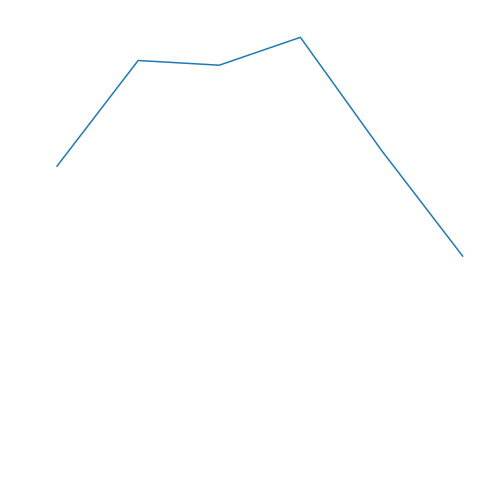

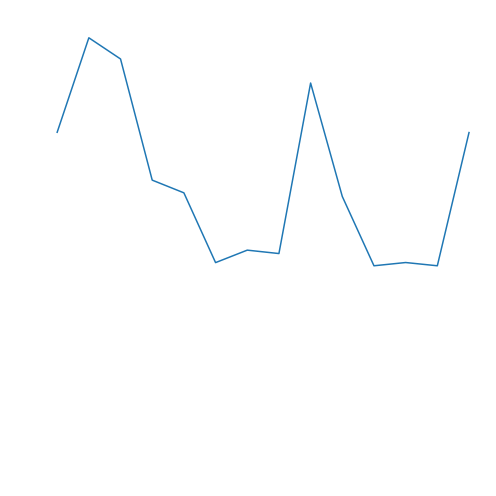

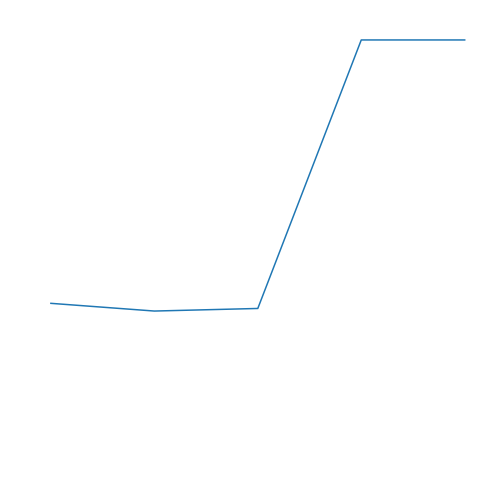

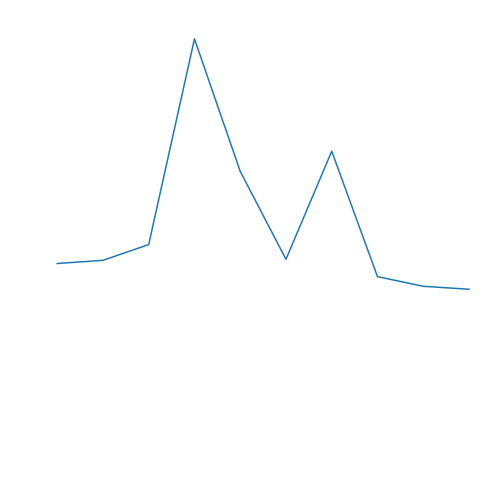

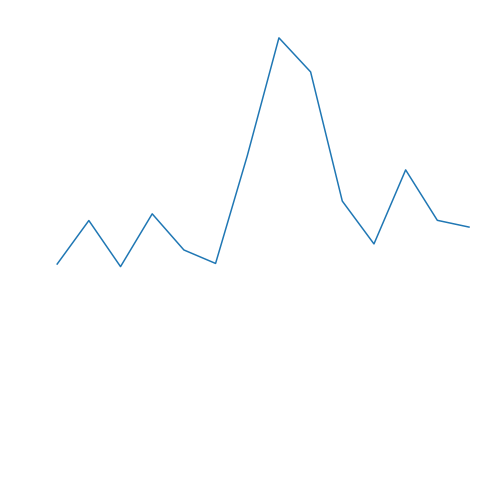

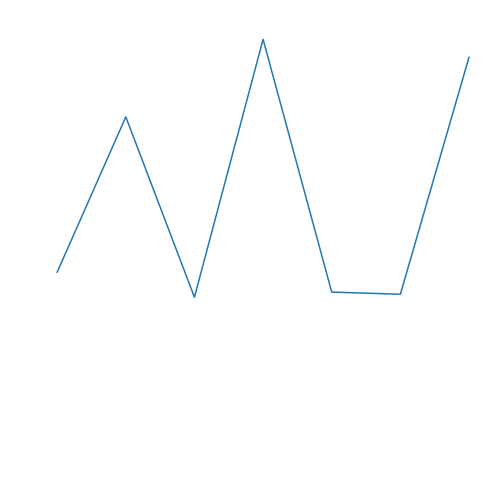

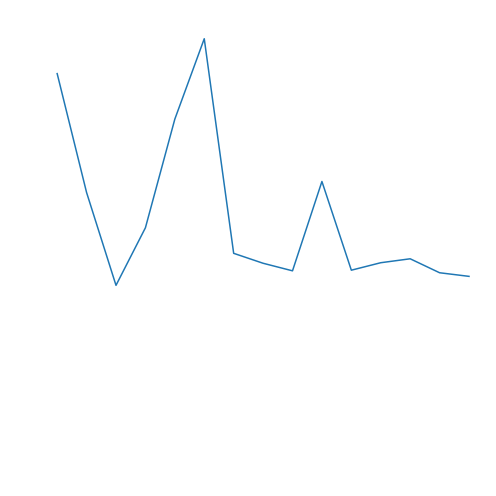

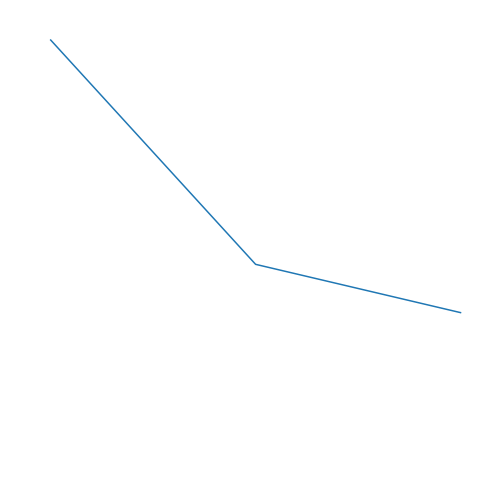

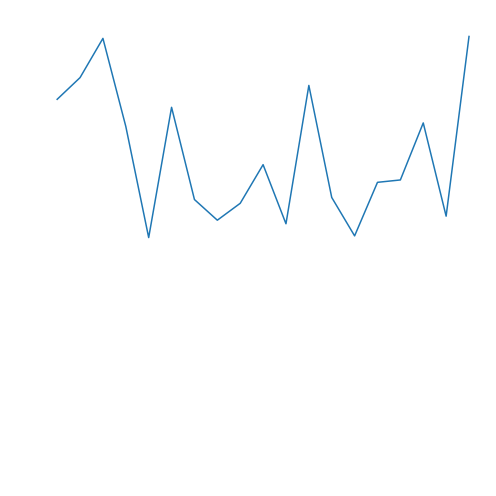

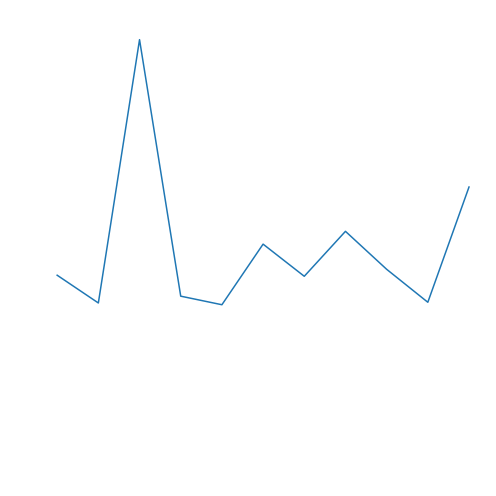

In [6]:
### 6) plot principal components using a threshold (here: 0.1)

params = {"text.color"  : "w",
          "ytick.color" : "w",
          "xtick.color" : "w",
          "xtick.labelsize"  : "8",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.autolayout" : "True"}
plt.rcParams.update(params)
for i in range(10):
    fig, ax = plot_comps_th(princ_comps, df_pca, i,0.1)
    plt.savefig(f'../docs/princ_comp{i+1}.png')


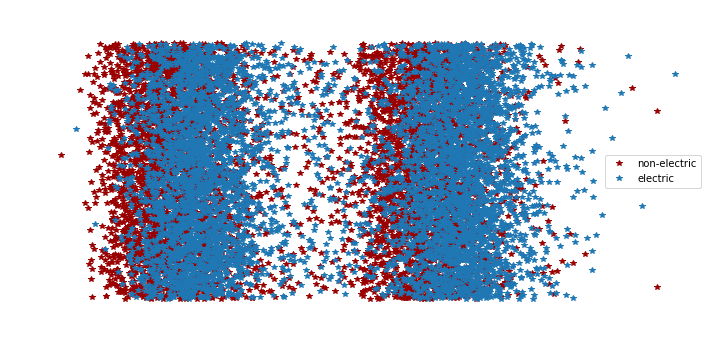

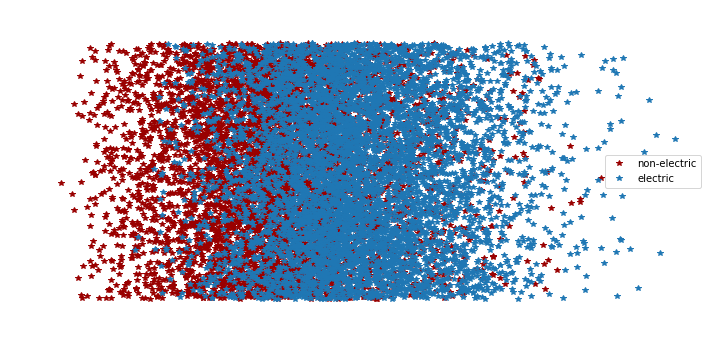

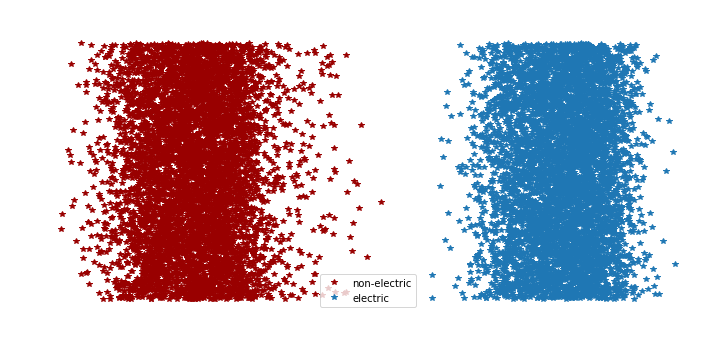

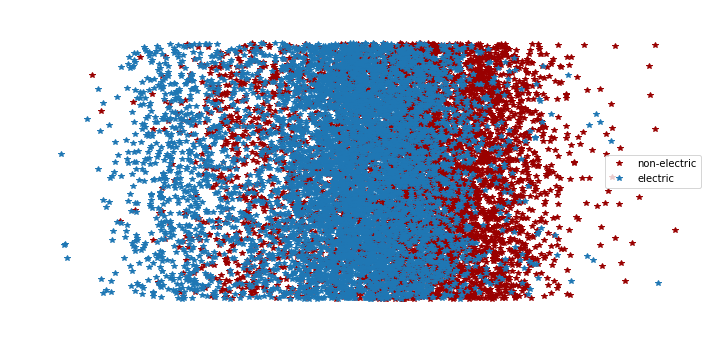

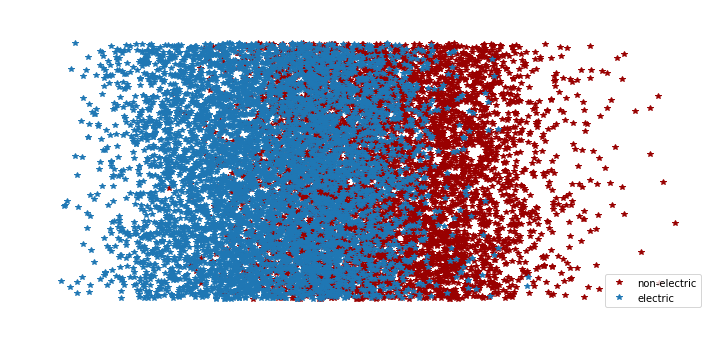

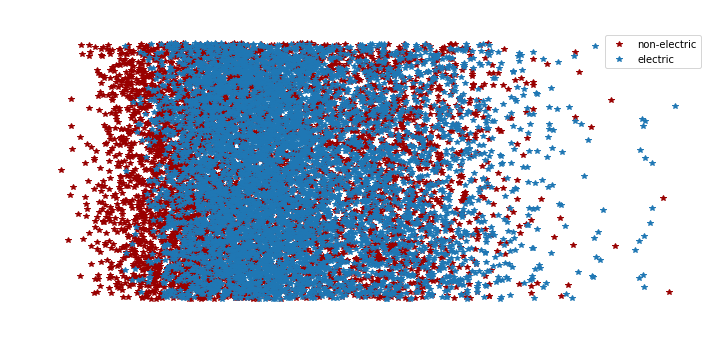

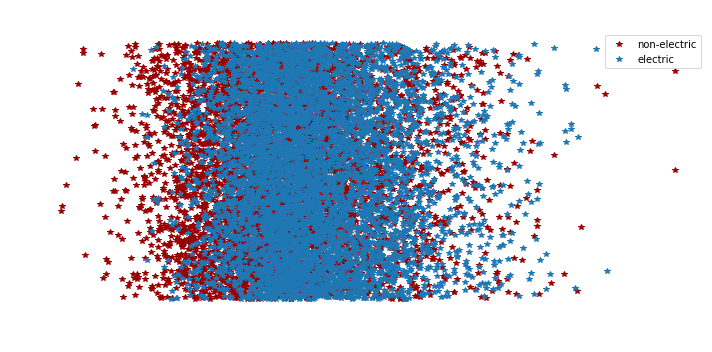

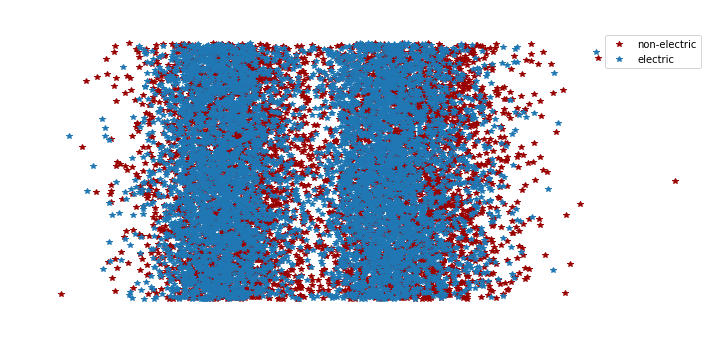

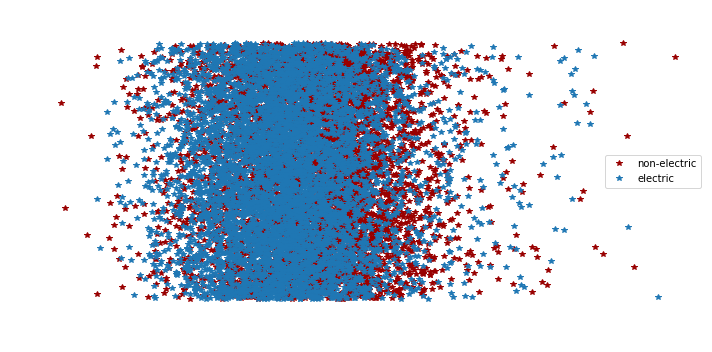

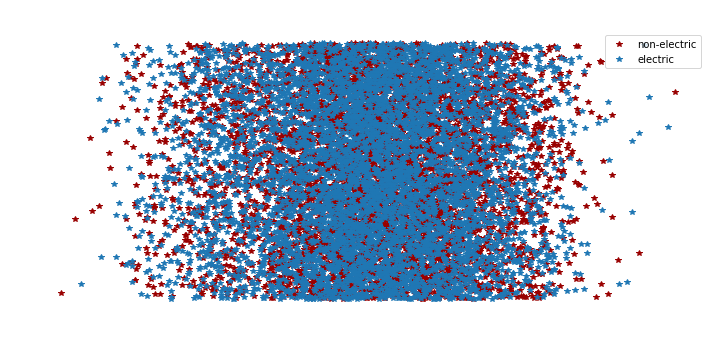

In [7]:
### 8) plot principal components as jitterplots with classes (EV/non-EV)

for i in range(10):
    fig, ax = plot_transf_data_electrics_one_comp(df_pca, transf_data, i)
    plt.savefig(f'../docs/princ_comp_classes{i+1}.png')


In [8]:
### split data in training and testing
from sklearn import model_selection
data = df_pca.drop(columns=['FUELTYPE_alternative_fuel', 'HYBRID_hybrid','HYBRID_no_hybrid', 'FUELTYPE_gas_fuel'])
target = df_pca.assign(el=(df_pca['FUELTYPE_alternative_fuel']==1).astype('category').cat.codes.values)['el']
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.30, random_state=42)

In [9]:
from sklearn.utils import resample 

train_data = pd.concat([X_train, y_train], axis=1)
non_el_ = train_data[train_data.el==0]
el_ = train_data[train_data.el==1]
pos_upsampled = resample(non_el_,
 replace=True, # sample with replacement
 n_samples=len(el_), # match number in majority class
 random_state=27) # reproducible results
# combine majority and upsampled minority
upsampled = pd.concat([el_, pos_upsampled])
# check new class counts
upsampled.el.value_counts()
X_train= upsampled.drop(columns = ['el'])
y_train= upsampled.el

In [10]:
### create a decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
clf = DecisionTreeClassifier(criterion="entropy")

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print( "Accuracy:",metrics.accuracy_score(y_test, y_pred))
print( "Precision:",metrics.precision_score(y_test, y_pred))
print( "Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7027883223639293
Precision: 0.11545608108108107
Recall: 0.7692740574001126


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print( "Accuracy:",metrics.accuracy_score(y_test, y_pred))
print( "Precision:",metrics.precision_score(y_test, y_pred))
print( "Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7621596526203676
Precision: 0.14618211514904042
Recall: 0.8058525604952167


Text(0.5, 1.0, 'Random forrest feature importance (only > 0.01)')

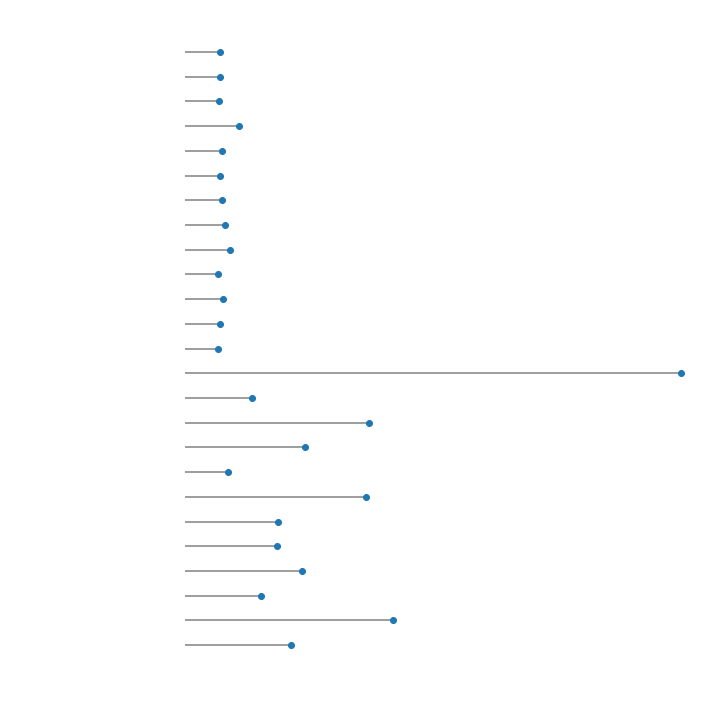

In [12]:
weights=model.feature_importances_
w_red = weights[weights>0.01]
X_test_red = X_test.columns[weights>0.01].values
fig, ax= plt.subplots(1,figsize=(10,10))
my_range=range(1,len(X_test_red)+1)
ax.hlines(y=X_test_red, xmin=0, xmax=w_red, color='grey')
ax.plot(w_red ,X_test_red, "o")   
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Random forrest feature importance (only > 0.01)')